In [1]:
import csv
import os
import sys
# Spark imports
from pyspark.rdd import RDD
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as f

In [3]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("NYC 311 Data Analysis") \
        .config('spark.sql.codegen.wholeStage', 'false') \
        .getOrCreate()
    return spark

In [4]:
filename = "311_Cleaned_Data_2018.csv"

In [5]:
spark = init_spark()

In [6]:
nyc_311_df = spark.read.format("csv").option("header", "true").load(filename)

In [7]:
nyc_311_df.printSchema()

root
 |-- Unique_Key: string (nullable = true)
 |-- Closing_timestamp: string (nullable = true)
 |-- Creation_timestamp: string (nullable = true)
 |-- time_to_resolve_in_hrs: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Open_Data_Channel_Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Complaint_Type: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Creation_Month: string (nullable = true)
 |-- Creation_Day: string (nullable = true)
 |-- Creation_Hour: string (nullable = true)
 |-- Closing_Month: string (nullable = true)
 |-- Closing_Day: string (nullable = true)
 |-- Closing_Hour: string (nullable = true)
 |-- Issue_Category: string (nullable = true)
 |-- Incident_Zip: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Created_Date: string (nullable = true)
 |-- Creation_Time: stri

In [8]:
nyc_311_df.take(10)

[Row(Unique_Key='38070822', Closing_timestamp='1527859895', Creation_timestamp='1514826009', time_to_resolve_in_hrs='3620.523888888889', Agency='HPD', Agency Name='Department of Housing Preservation and Development', Open_Data_Channel_Type='MOBILE', Status='Closed', Complaint_Type='HEAT/HOT WATER', Borough='BRONX', Creation_Month='1', Creation_Day='1', Creation_Hour='0', Closing_Month='6', Closing_Day='1', Closing_Hour='9', Issue_Category='HOUSE_HOLD_CLEANING_ISSUES', Incident_Zip='10468.0', City='BRONX', Latitude='40.869888878158', Longitude='-73.89519628318175', Created_Date='01/01/2018 12:00:09 AM', Creation_Time='12:00:09 AM', Closed_Date='01/06/2018 09:31:35 AM', Closing_Time='09:31:35 AM'),
 Row(Unique_Key='38065299', Closing_timestamp='1515941092', Creation_timestamp='1514826105', time_to_resolve_in_hrs='309.7186111111111', Agency='HPD', Agency Name='Department of Housing Preservation and Development', Open_Data_Channel_Type='PHONE', Status='Closed', Complaint_Type='PLUMBING', B

In [9]:
nyc_311_df.select("Agency").distinct().show()

+------+
|Agency|
+------+
|   HPD|
|  NYPD|
|   DEP|
|  DSNY|
+------+



In [10]:
nyc_311_df.select("Complaint_Type").distinct().show()

+--------------------+
|      Complaint_Type|
+--------------------+
|UNSANITARY CONDITION|
|     Illegal Parking|
| Noise - Residential|
|  Noise - Commercial|
|        Water System|
|    Blocked Driveway|
|      HEAT/HOT WATER|
|       PAINT/PLASTER|
|               Noise|
|Request Large Bul...|
|            PLUMBING|
|          WATER LEAK|
|Noise - Street/Si...|
+--------------------+



In [11]:
agency_to_time_resolve = nyc_311_df.select('Agency', nyc_311_df.time_to_resolve_in_hrs.cast('float').alias('time_to_resolve_in_hrs'))

In [12]:
agency_to_time_resolve.show()

+------+----------------------+
|Agency|time_to_resolve_in_hrs|
+------+----------------------+
|   HPD|              3620.524|
|   HPD|              309.7186|
|   HPD|              4338.867|
|   HPD|             1412.5331|
|   HPD|             3619.5586|
|   HPD|             5082.2495|
|   HPD|              4341.041|
|   HPD|             5082.2153|
|   HPD|              6541.809|
|   HPD|             3621.0168|
|   HPD|             7285.0396|
|   DEP|           0.016666668|
|   HPD|               277.945|
|   HPD|             7293.3154|
|   HPD|             5076.9204|
|   HPD|              5082.142|
|   HPD|             3620.6353|
|   HPD|             279.63943|
|   HPD|             733.83026|
|   HPD|             4335.1694|
+------+----------------------+
only showing top 20 rows



In [13]:
agency_to_time_resolve_mean = agency_to_time_resolve.groupBy("Agency").mean("time_to_resolve_in_hrs")

In [14]:
agency_to_time_resolve_mean.show()

+------+---------------------------+
|Agency|avg(time_to_resolve_in_hrs)|
+------+---------------------------+
|   HPD|         1321.8216605033401|
|  NYPD|          87.78033624056667|
|   DEP|          778.9374559487497|
|  DSNY|          982.5216570626686|
+------+---------------------------+



In [17]:
import matplotlib.pyplot as plt
def create_x_y_coordinates_for_group_by_results(group_by_result, col_name, isMean=False):
    '''
    Converts Group By Result (after collect()) into list of X , Y coordinates, which can then be used for Visualizations
    '''
    x = [entry.__getitem__(col_name) for entry in group_by_result]
    if isMean:
        y = [entry.__getitem__("avg(time_to_resolve_in_hrs)") for entry in group_by_result]
    else:
        y = [entry.__getitem__("count") for entry in group_by_result]
    
    return x, y


def plot_chart_x_y(x, y, title, x_label, y_label, fig_num, x_ticks=None, x_ticks_lables=None, y_ticks=None,
                   y_ticks_lables=None, rotation=None):
    plt.figure(num=fig_num, figsize=(8, 4))

    plt.bar(x, y, align='center', color='blue', alpha=.5)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if x_ticks is not None:
        if x_ticks_lables is not None:
            plt.xticks(x_ticks, x_ticks_lables)
        else:
            plt.xticks(x_ticks)
    if y_ticks is not None:
        if y_ticks_lables is not None:
            plt.yticks(y_ticks, y_ticks_lables)
        else:
            plt.yticks(y_ticks)

    if rotation is not None:
        plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig("" + str(fig_num) + '.png')


def prepare_plot(df, col_name, title, x_label, y_label, fig_num, rotation=None, isMean=False, x_ticks=None, x_ticks_lables=None, y_ticks=None,
                 y_ticks_lables=None):
    if isMean:
        df_groupby_col = df.groupby(col_name).mean(y_label).orderBy(col_name).collect()
    else:
        df_groupby_col = df.groupby(col_name).count().orderBy(col_name).collect()
    
    x, y = create_x_y_coordinates_for_group_by_results(df_groupby_col, col_name, isMean)
    plot_chart_x_y(x, y, title, x_label, y_label, fig_num, x_ticks, x_ticks_lables, y_ticks, y_ticks_lables, rotation)


def show_plot():
    plt.show()

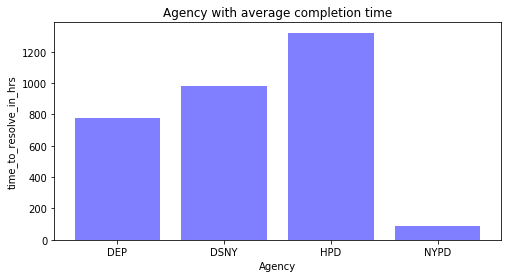

In [19]:
prepare_plot(agency_to_time_resolve, 'Agency',
                            "Agency with average completion time",
                            "Agency", "time_to_resolve_in_hrs", 1, None, True)

In [20]:
complaint_type_to_time_resolve = nyc_311_df.select('Complaint_Type', nyc_311_df.time_to_resolve_in_hrs.cast('float').alias('time_to_resolve_in_hrs'))

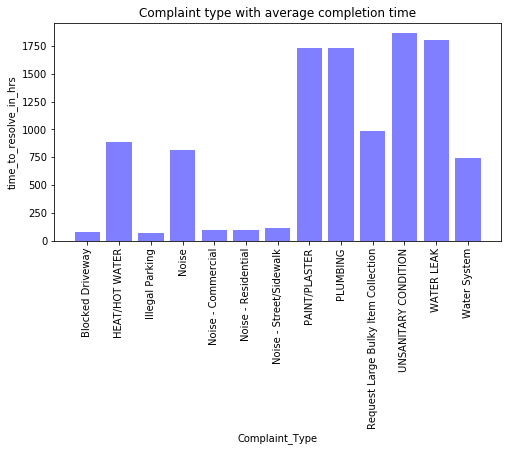

In [21]:
prepare_plot(complaint_type_to_time_resolve, 'Complaint_Type',
                            "Complaint type with average completion time",
                            "Complaint_Type", "time_to_resolve_in_hrs", 2, 90, True)

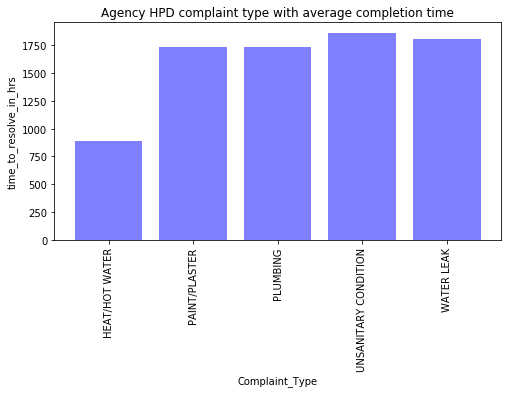

In [22]:
complaint_type_to_time_resolve = nyc_311_df.select('Complaint_Type', 'Agency',nyc_311_df.time_to_resolve_in_hrs.cast('float').alias('time_to_resolve_in_hrs'))
prepare_plot(complaint_type_to_time_resolve.filter(complaint_type_to_time_resolve["Agency"]=="HPD"), 'Complaint_Type',
                            "Agency HPD complaint type with average completion time",
                            "Complaint_Type", "time_to_resolve_in_hrs", 3, 90, True)

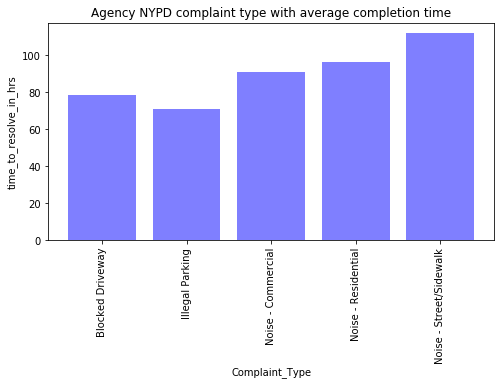

In [23]:
prepare_plot(complaint_type_to_time_resolve.filter(complaint_type_to_time_resolve["Agency"]=="NYPD"), 'Complaint_Type',
                            "Agency NYPD complaint type with average completion time",
                            "Complaint_Type", "time_to_resolve_in_hrs", 4, 90, True)

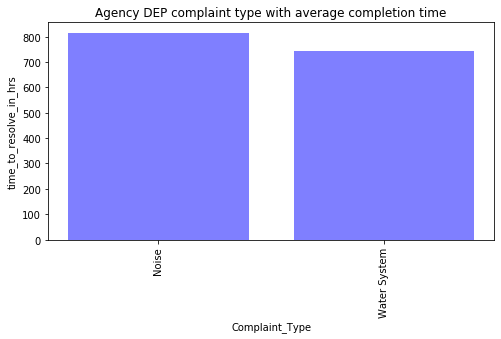

In [24]:
prepare_plot(complaint_type_to_time_resolve.filter(complaint_type_to_time_resolve["Agency"]=="DEP"), 'Complaint_Type',
                            "Agency DEP complaint type with average completion time",
                            "Complaint_Type", "time_to_resolve_in_hrs", 5, 90, True)

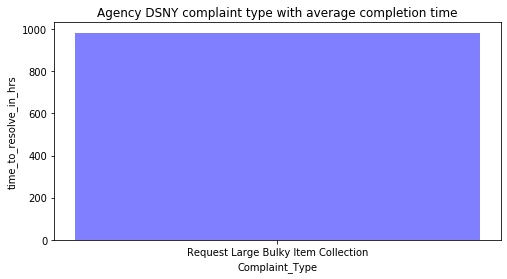

In [26]:
prepare_plot(complaint_type_to_time_resolve.filter(complaint_type_to_time_resolve["Agency"]=="DSNY"), 'Complaint_Type',
                            "Agency DSNY complaint type with average completion time",
                            "Complaint_Type", "time_to_resolve_in_hrs", 6, None, True)

In [27]:
nyc_311_df.select("Open_Data_Channel_Type").distinct().show()

+----------------------+
|Open_Data_Channel_Type|
+----------------------+
|                MOBILE|
|               UNKNOWN|
|                 OTHER|
|                 PHONE|
|                ONLINE|
+----------------------+



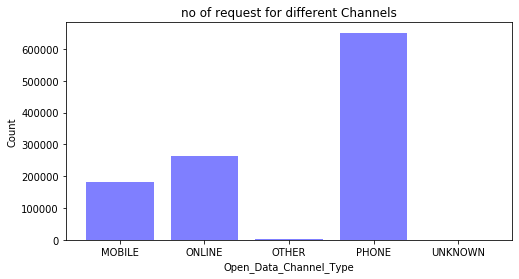

In [28]:
prepare_plot(nyc_311_df, 'Open_Data_Channel_Type',
                            "no of request for different Channels",
                            "Open_Data_Channel_Type", "Count", 8, None, False)